In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
def load_igs_csv(path):
    raw = pd.read_csv(path)

    # 1) Find the row that actually contains "Year"
    header_row_idx = None
    max_rows_to_scan = min(10, len(raw))  # just in case

    for i in range(max_rows_to_scan):
        row = raw.iloc[i].astype(str)
        if (row == "Year").any():
            header_row_idx = i
            break

    if header_row_idx is None:
        raise ValueError(
            f"Could not find a 'Year' cell in the first {max_rows_to_scan} rows of {path}. "
            f"Columns are: {list(raw.columns)}"
        )

    # 2) Use that row as header
    header = raw.iloc[header_row_idx]
    df = raw.rename(columns=header)

    # 3) Drop all rows up to and including the header row,
    #    plus one more row (IGS often has a blank/meta row under the header)
    df = df.iloc[header_row_idx + 2 :].reset_index(drop=True)

    # 4) Make sure "Year" exists and is numeric
    if "Year" not in df.columns:
        raise ValueError(f"'Year' not found as a column after header fix in {path}. "
                         f"Columns are now: {df.columns.tolist()}")

    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

    return df


Selma Internet Access Tract %:
 Year
2020    67.090909
2021    78.490909
2022    78.190909
2023    79.790909
2024    79.790909
Name: Internet Access Tract, %, dtype: float64 

Detroit Internet Access Tract %:
 Year
2019    58.965565
2020    61.201377
2021    73.029942
2022    76.951453
2023    80.163930
Name: Internet Access Tract, %, dtype: float64 

Detroit delta per year: 5.299591220119082
Selma delta per year: 3.1750000000000007
Selma projected (Detroit-style): [85.09050031 90.39009153 95.68968275]
Selma projected (same trend): [82.96590909 86.14090909 89.31590909]


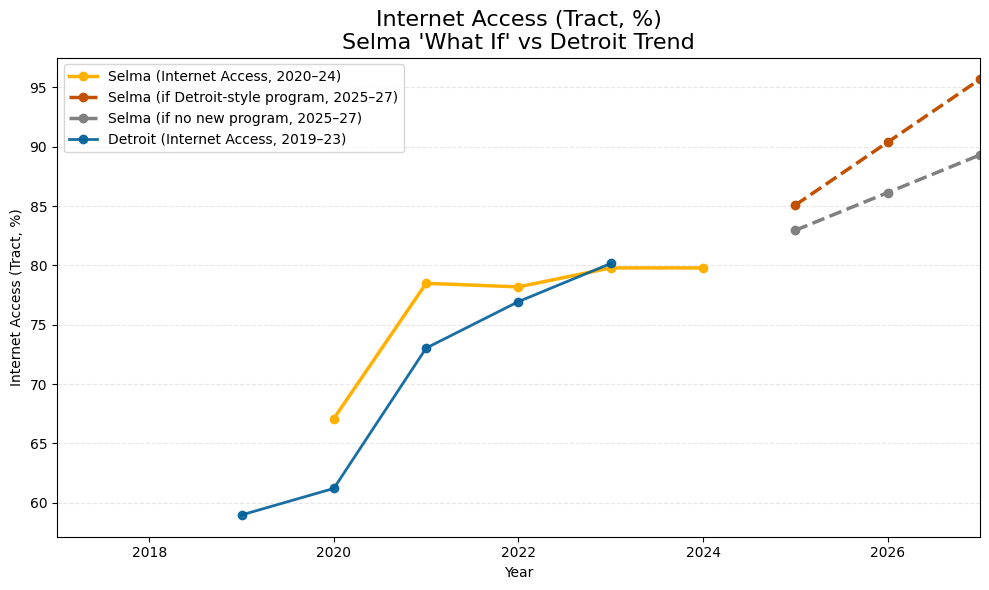


Selma Internet Access – projected if Detroit-style program (2025–2027):
  2025: 85.09%
  2026: 90.39%
  2027: 95.69%


In [61]:


# 1. Loader
def load_igs_csv(path):
    raw = pd.read_csv(path, header=None)
    header = raw.iloc[1]
    df = raw.rename(columns=header).iloc[3:].reset_index(drop=True)
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    return df

# 2. Load Selma + Detroit
selma_df   = load_igs_csv("Selma/Compared to USA.csv")
detroit_df = load_igs_csv("Detroit/Compared to USA.csv")

metric    = "Internet Access"
tract_col = f"{metric} Tract, %"

for df in (selma_df, detroit_df):
    df[tract_col] = pd.to_numeric(df[tract_col], errors="coerce")

# 3. Time series on TRACT %

# Selma: 2020–2024
selma_ts = (
    selma_df.groupby("Year")[tract_col]
    .mean()
    .loc[2020:2024]
    .dropna()
)

# Detroit: 2019–2023 (you can adjust window if you want)
detroit_ts = (
    detroit_df.groupby("Year")[tract_col]
    .mean()
    .loc[2019:2023]
    .dropna()
)

print("Selma Internet Access Tract %:\n", selma_ts, "\n")
print("Detroit Internet Access Tract %:\n", detroit_ts, "\n")

# 4. Trend in TRACT %

detroit_delta = (detroit_ts.iloc[-1] - detroit_ts.iloc[0]) / (len(detroit_ts) - 1)
selma_delta   = (selma_ts.iloc[-1]   - selma_ts.iloc[0])   / (len(selma_ts)   - 1)

last_selma   = selma_ts.iloc[-1]          # Selma value in 2024
future_years = np.array([2025, 2026, 2027])

# Scenario A: Selma if it improves at Detroit’s rate
selma_if_detroit = last_selma + detroit_delta * np.arange(1, len(future_years) + 1)

# (Optional) Scenario B: Selma if it keeps its own recent rate
selma_if_same = last_selma + selma_delta * np.arange(1, len(future_years) + 1)

print("Detroit delta per year:", detroit_delta)
print("Selma delta per year:", selma_delta)
print("Selma projected (Detroit-style):", selma_if_detroit)
print("Selma projected (same trend):", selma_if_same)

# 5. Plot – pure Tract %

plt.figure(figsize=(10, 6))

# Selma actual
plt.plot(
    selma_ts.index, selma_ts.values,
    marker="o", linewidth=2.5,
    color="#ffb000",
    label="Selma (Internet Access, 2020–24)"
)

# Selma projected – Detroit-style improvement
plt.plot(
    future_years, selma_if_detroit,
    marker="o", linestyle="--", linewidth=2.5,
    color="#c15100",
    label="Selma (if Detroit-style program, 2025–27)"
)

# Selma projected – same trend (optional)
plt.plot(
    future_years, selma_if_same,
    marker="o", linestyle="--", linewidth=2.5,
    color="gray",
    label="Selma (if no new program, 2025–27)"
)

# Detroit actual
plt.plot(
    detroit_ts.index, detroit_ts.values,
    marker="o", linewidth=2.0,
    color="#005f99", alpha=0.9,
    label="Detroit (Internet Access, 2019–23)"
)

plt.title("Internet Access (Tract, %)\nSelma 'What If' vs Detroit Trend", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Internet Access (Tract, %)")
plt.xlim(2017, 2027)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# After:
# selma_if_detroit = last_selma + detroit_delta * np.arange(1, len(future_years) + 1)

print("\nSelma Internet Access – projected if Detroit-style program (2025–2027):")
for year, val in zip(future_years, selma_if_detroit):
    print(f"  {year}: {val:.2f}%")



Selma ts:
 Year
2020    81.154545
2021    81.590909
2022    81.700000
2023    82.545455
2024    82.545455
Name: Affordable Housing Tract, %, dtype: float64

Rutland ts:
 Year
2019    72.04
2020    72.30
2021    75.54
2022    78.12
2023    78.48
Name: Affordable Housing Tract, %, dtype: float64

Rutland delta per year: 1.6099999999999994
Selma delta per year: 0.34772727272727266
Selma projected if Rutland trend: [84.15545455 85.76545455 87.37545455]
Selma projected if no new program: [82.89318182 83.24090909 83.58863636]


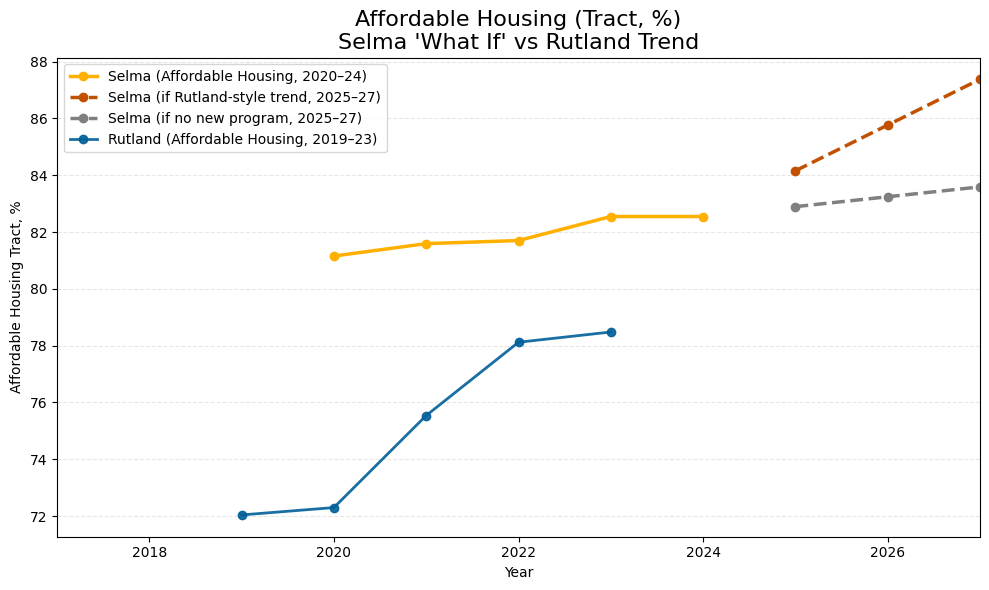


Selma Affordable Housing – projected if Rutland-style program (2025–2027):
  2025: 84.16%
  2026: 85.77%
  2027: 87.38%


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Loader (same pattern as before) ---
def load_igs_csv(path):
    raw = pd.read_csv(path, header=None)
    header = raw.iloc[1]
    df = raw.rename(columns=header).iloc[3:].reset_index(drop=True)
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    return df

# --- 2. Load Selma + Rutland IGS CSVs ---
selma_df   = load_igs_csv("Selma/Compared to USA.csv")
rutland_df = load_igs_csv("Rutland/Compared to USA.csv")

# 3. Metric: Affordable Housing (TRACT level)
metric = "Affordable Housing"
col = f"{metric} Tract, %"

for df in (selma_df, rutland_df):
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 4. Build time series

selma_ts = (
    selma_df.groupby("Year")[col]
    .mean()
    .loc[2020:2024]
    .dropna()
)

rut_ts = (
    rutland_df.groupby("Year")[col]
    .mean()
    .loc[2019:2023]
    .dropna()
)

print("Selma ts:\n", selma_ts)
print("\nRutland ts:\n", rut_ts)

# 5. Compute trends

rut_delta   = (rut_ts.iloc[-1]   - rut_ts.iloc[0])   / (len(rut_ts)   - 1)
selma_delta = (selma_ts.iloc[-1] - selma_ts.iloc[0]) / (len(selma_ts) - 1)

last_selma   = selma_ts.iloc[-1]
future_years = np.array([2025, 2026, 2027])

selma_if_rut  = last_selma + rut_delta   * np.arange(1, len(future_years) + 1)
selma_if_same = last_selma + selma_delta * np.arange(1, len(future_years) + 1)

print("\nRutland delta per year:", rut_delta)
print("Selma delta per year:", selma_delta)
print("Selma projected if Rutland trend:", selma_if_rut)
print("Selma projected if no new program:", selma_if_same)

# 6. Plot

plt.figure(figsize=(10, 6))

plt.plot(
    selma_ts.index, selma_ts.values,
    marker="o", linewidth=2.5,
    color="#ffb000", label="Selma (Affordable Housing, 2020–24)"
)

plt.plot(
    future_years, selma_if_rut,
    marker="o", linestyle="--", linewidth=2.5,
    color="#c15100", label="Selma (if Rutland-style trend, 2025–27)"
)

plt.plot(
    future_years, selma_if_same,
    marker="o", linestyle="--", linewidth=2.5,
    color="gray", label="Selma (if no new program, 2025–27)"
)

plt.plot(
    rut_ts.index, rut_ts.values,
    marker="o", linewidth=2.0,
    color="#005f99", alpha=0.9,
    label="Rutland (Affordable Housing, 2019–23)"
)

plt.title("Affordable Housing (Tract, %)\nSelma 'What If' vs Rutland Trend", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Affordable Housing Tract, %")
plt.xlim(2017, 2027)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Pretty print: Selma Affordable Housing if Rutland-style program (2025–27)
print("\nSelma Affordable Housing – projected if Rutland-style program (2025–2027):")
for year, val in zip(future_years, selma_if_rut):
    print(f"  {year}: {val:.2f}%")



Selma Minority/Women Owned Businesses Tract %:
 Year
2020    6.744444
2021    8.418182
2022    8.145455
2023    6.681818
2024    7.840000
Name: Minority/Women Owned Businesses Tract, %, dtype: float64 

Natchez Minority/Women Owned Businesses Tract %:
 Year
2019     7.233333
2020     5.162500
2021    10.100000
2022    12.000000
Name: Minority/Women Owned Businesses Tract, %, dtype: float64 

Natchez delta per year: 1.5888888888888892
Selma delta per year: 0.27388888888888907


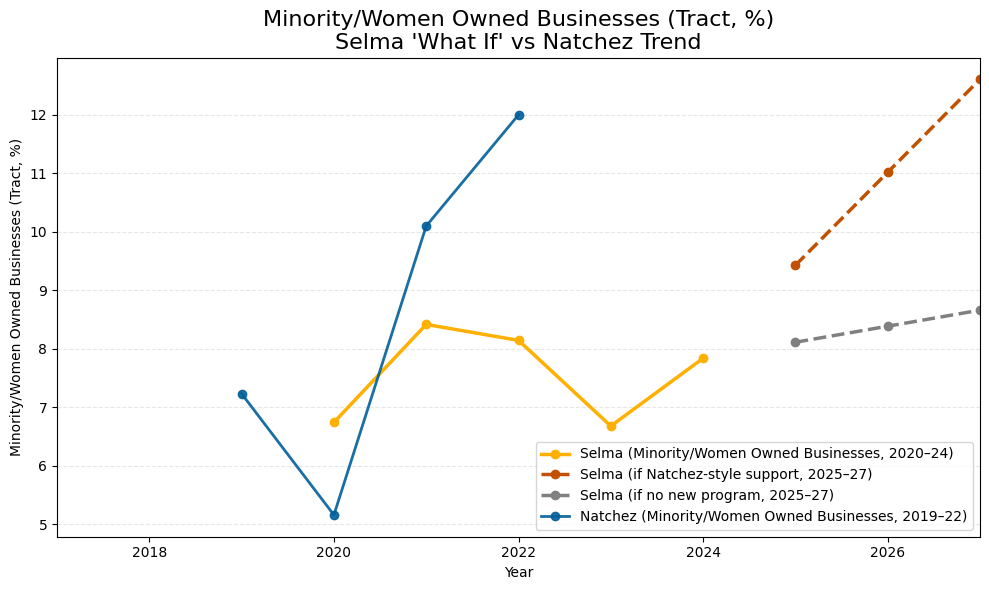


Selma Minority/Women Owned Businesses – projected if Natchez-style support (2025–2027):
  2025: 9.43%
  2026: 11.02%
  2027: 12.61%


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Loader (same pattern as before) ---
def load_igs_csv(path):
    raw = pd.read_csv(path, header=None)
    header = raw.iloc[1]
    df = raw.rename(columns=header).iloc[3:].reset_index(drop=True)
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    return df

# --- 2. Load Selma + Natchez ---
selma_df  = load_igs_csv("Selma/Compared to USA.csv")
nat_df    = load_igs_csv("Natchez/Compared to USA.csv")   # <- peer city

metric    = "Minority/Women Owned Businesses"
tract_col = f"{metric} Tract, %"

for df in (selma_df, nat_df):
    df[tract_col] = pd.to_numeric(df[tract_col], errors="coerce")

# --- 3. Build time series on TRACT % ---

# Selma: use 2020–2024 (consistent with other charts)
selma_ts = (
    selma_df.groupby("Year")[tract_col]
    .mean()
    .loc[2020:2024]
    .dropna()
)

# Natchez: 2019–2022 (your chosen window)
nat_ts = (
    nat_df.groupby("Year")[tract_col]
    .mean()
    .loc[2019:2022]
    .dropna()
)

print("Selma Minority/Women Owned Businesses Tract %:\n", selma_ts, "\n")
print("Natchez Minority/Women Owned Businesses Tract %:\n", nat_ts, "\n")

# --- 4. Compute trends in TRACT % ---

nat_delta   = (nat_ts.iloc[-1]   - nat_ts.iloc[0])   / (len(nat_ts)   - 1)
selma_delta = (selma_ts.iloc[-1] - selma_ts.iloc[0]) / (len(selma_ts) - 1)

last_selma   = selma_ts.iloc[-1]          # Selma Tract % in 2024
future_years = np.array([2025, 2026, 2027])

# Scenario A: Selma if it improves at Natchez's rate
selma_if_nat = last_selma + nat_delta * np.arange(1, len(future_years) + 1)

# Scenario B: Selma if it just keeps its own recent rate (no new program)
selma_if_same = last_selma + selma_delta * np.arange(1, len(future_years) + 1)

print("Natchez delta per year:", nat_delta)
print("Selma delta per year:", selma_delta)

# --- 5. Plot ---

plt.figure(figsize=(10, 6))

# Selma actual
plt.plot(
    selma_ts.index, selma_ts.values,
    marker="o", linewidth=2.5,
    color="#ffb000",  # same Selma color as your internet chart
    label="Selma (Minority/Women Owned Businesses, 2020–24)"
)

# Selma projected – if Natchez-style improvement
plt.plot(
    future_years, selma_if_nat,
    marker="o", linestyle="--", linewidth=2.5,
    color="#c15100",  # same projected-program color
    label="Selma (if Natchez-style support, 2025–27)"
)

# Selma projected – if no new program
plt.plot(
    future_years, selma_if_same,
    marker="o", linestyle="--", linewidth=2.5,
    color="gray",
    label="Selma (if no new program, 2025–27)"
)

# Natchez actual
plt.plot(
    nat_ts.index, nat_ts.values,
    marker="o", linewidth=2.0,
    color="#005f99",  # same peer-city blue
    alpha=0.9,
    label="Natchez (Minority/Women Owned Businesses, 2019–22)"
)

plt.title("Minority/Women Owned Businesses (Tract, %)\nSelma 'What If' vs Natchez Trend", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Minority/Women Owned Businesses (Tract, %)")
plt.xlim(2017, 2027)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# After:
# selma_if_nat = last_selma + nat_delta * np.arange(1, len(future_years) + 1)

print("\nSelma Minority/Women Owned Businesses – projected if Natchez-style support (2025–2027):")
for year, val in zip(future_years, selma_if_nat):
    print(f"  {year}: {val:.2f}%")


IGS model fitted. Coefficients:
  Internet Access Tract, %: 0.2382
  Minority/Women Owned Businesses Tract, %: 0.3061
  Affordable Housing Tract, %: 0.0932
Intercept: 12.14284773644518

Predicted Selma IGS under 3-program scenario:
   Year  Predicted IGS
0  2025      59.059310
1  2026      60.963166
2  2027      62.867022


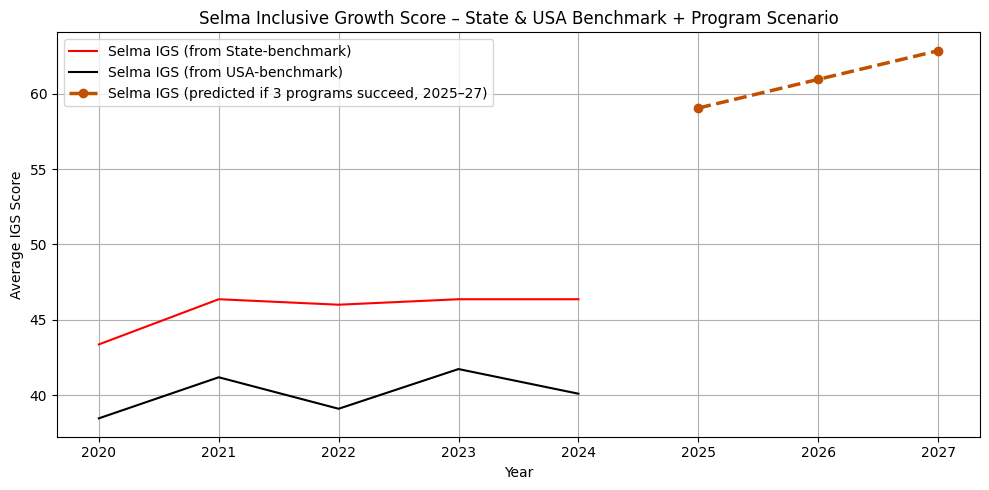

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ---------- 1. Load the raw CSVs for Selma vs State & USA ----------
df_state = pd.read_csv("Selma/Compared to State.csv")
df_usa   = pd.read_csv("Selma/Compared to USA.csv")

# ---------- 2. Clean into Year + IGS (your earlier logic) ----------

# State
s = df_state.rename(columns={'Unnamed: 5': 'Year', 'SUMMARY': 'IGS'})
s = s[(s['Year'].notna()) & (s['IGS'].notna())]
s = s[pd.to_numeric(s['IGS'], errors='coerce').notna()]
s['IGS']  = s['IGS'].astype(float)
s['Year'] = s['Year'].astype(int)
avg_state = s.groupby('Year')['IGS'].mean()

# USA (Selma vs USA export)
u = df_usa.rename(columns={'Unnamed: 5': 'Year', 'SUMMARY': 'IGS'})
u = u[(u['Year'].notna()) & (u['IGS'].notna())]
u = u[pd.to_numeric(u['IGS'], errors='coerce').notna()]
u['IGS']  = u['IGS'].astype(float)
u['Year'] = u['Year'].astype(int)
avg_usa   = u.groupby('Year')['IGS'].mean()

# ---------- 3. Fit IGS model on Selma tracts using 3 levers ----------

# Reuse the cleaner header-style loader for the USA file with full metrics
def load_igs_csv(path):
    raw = pd.read_csv(path, header=None)
    header = raw.iloc[1]
    df = raw.rename(columns=header).iloc[3:].reset_index(drop=True)
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    return df

selma_full = load_igs_csv("Selma/Compared to USA.csv")

igs_col = "Inclusive Growth Score"
x_cols  = [
    "Internet Access Tract, %",
    "Minority/Women Owned Businesses Tract, %",
    "Affordable Housing Tract, %",
]

df_model = selma_full[x_cols + [igs_col]].copy()
for c in x_cols + [igs_col]:
    df_model[c] = pd.to_numeric(df_model[c], errors="coerce")

df_model = df_model.dropna(subset=x_cols + [igs_col])

X = df_model[x_cols].values
y = df_model[igs_col].values

igs_model = LinearRegression()
igs_model.fit(X, y)

print("IGS model fitted. Coefficients:")
for name, coef in zip(x_cols, igs_model.coef_):
    print(f"  {name}: {coef:.4f}")
print("Intercept:", igs_model.intercept_)

# ---------- 4. Your 2025–2027 program-engaged projections ----------

future_igs_df = pd.DataFrame({
    "Year": [2025, 2026, 2027],
    "Internet Access Tract, %": [
      85.09,
        90.39,
        95.69,
    ],
    "Minority/Women Owned Businesses Tract, %": [
    84.16,
  85.77,
  87.38,
    ],
    "Affordable Housing Tract, %": [
    9.43,
  11.02,
  12.61,
    ],
})

X_future = future_igs_df[x_cols].values
future_igs_df["Predicted IGS"] = igs_model.predict(X_future)

print("\nPredicted Selma IGS under 3-program scenario:")
print(future_igs_df[["Year", "Predicted IGS"]])

# ---------- 5. Plot: State IGS, USA IGS, and Program Scenario ----------

plt.figure(figsize=(10,5))

plt.plot(avg_state.index, avg_state.values,
         label="Selma IGS (from State-benchmark)",
         color="red")

plt.plot(avg_usa.index, avg_usa.values,
         label="Selma IGS (from USA-benchmark)",
         color="black")

plt.plot(
    future_igs_df["Year"],
    future_igs_df["Predicted IGS"],
    marker="o",
    linestyle="--",
    linewidth=2.5,
    color="#c15100",
    label="Selma IGS (predicted if 3 programs succeed, 2025–27)"
)

plt.xlabel("Year")
plt.ylabel("Average IGS Score")
plt.title("Selma Inclusive Growth Score – State & USA Benchmark + Program Scenario")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
